In [ ]:
import os
import re
import json
import logging
import requests
import numpy as np
import pandas as pd
from time import sleep
from warnings import warn
from getpass import getuser
from datetime import datetime
from bs4 import BeautifulSoup
from tqdm.notebook import tqdm

class BursaScraper:
    """
    path (str): Absolute path, default to "Documents", it is the location to store scraped information as well    
    
    Sample Code:
    
    bursa = BursaScraper()
    tickers = bursa.sample(n_ticker=10)                      
    statements = bursa.collect_statements(codes=tickers)            
    statements[list(statements.keys())[0]]['INC']    
    """
    def __init__(self, path=None):        
        if path is None: path = f'C:/Users/{getuser()}/Documents'
        self.path = path
        os.chdir(path)        
        self.response = None
        self.text = None
        self.total_page = None
        self.records = None
        self.stock_infos = []
        self.fail_tickers = []
        self.tickers = pd.DataFrame()
    
    def log_error(self, file_name='Logger Statement'):              
        tickers = self.fail_tickers
        if len(tickers) == 0: 
            logging.info('No error found.')            
        else:
            with open(file_name, 'a+') as log:
                for ticker in tickers: log.write(datetime.now(), f'--- Fail to collect {ticker}, please check.')
                                
    def collect_ticker(self, local=True, write=True):
        if local: 
            try:
                return pd.read_excel(os.path.join(self.path, 'tickers.xlsx'))
            except Exception as e:
                logging.warning(e)
                logging.warning('Fail to read file from local path, extracting from website...')
                pass
        
        page = 1                
        ticker_url =  f'http://www.bursamarketplace.com/index.php?screentype=stocks&board=all&tpl=screener_ajax&type=getResult&action=listing&pagenum={page}&sfield=name&stype=desc'                                
        self.response = requests.get(ticker_url)
        self.text = json.loads(self.response.text)
        self.total_page = int(self.text['totalpage'])        
        
        for i in range(1, self.total_page+1):        
            for attempt in range(3):
                try:
                    page += 1
                    ticker_url = f'http://www.bursamarketplace.com/index.php?screentype=stocks&board=all&tpl=screener_ajax&type=getResult&action=listing&pagenum={page}&sfield=name&stype=desc'                                                    
                    response = requests.get(ticker_url)
                except:
                    logging.warning(f'\nFail at page {i}, attempt {attempt}')                                
                    sleep(0.5)
                else:
                    break
        
            self.text = json.loads(response.text)
            records = self.text['records']            
            if isinstance(records, dict): records = list(records.values())
            self.records = records            
            self.stock_infos.append([{k:v for k, v in record.items()} for record in records])
                
        self.tickers = pd.DataFrame.from_dict(sum(self.stock_infos, []))        
                
        try:
            numeric_cols = ['avgrating', 'price', 'mktcap', 'pev', 'pbv', 'estpeg', 'divyld']
            self.tickers[numeric_cols] = self.tickers[numeric_cols].astype(float)
        except:
            pass
        
        if write:
            output_path = os.path.join(self.path, 'tickers.xlsx')
            self.tickers.to_excel(output_path, sheet_name='stock_info', index=False)
            logging.info(f'Tickers output to {output_path}')            
            
        return self.tickers
    
    def _collect_statement(self, code=None, frequency='quarter', verbose=True):
        fq = {'quarter': 'qr', 'annual': 'yr'}[frequency]
        st_code = {'INC': 'is', 'BAL': 'bs', 'CAS': 'cf'}        
        path = code.split('.')[0] + '_' + fq + '.xlsx'    
        results = dict()        
        missing_data = []
        
        if os.path.isfile(path):        
            xlsx = pd.ExcelFile(path)
            for st in st_code.keys(): results[st] = pd.read_excel(xlsx, sheet=st)    
        else:
            for st in st_code.keys(): results[st] = pd.DataFrame()
                            
        for st in st_code.keys():
            url = f'http://www.bursamarketplace.com/index.php?tpl=financial_ajax&type=stockfin{st_code[st]+frequency}&code={code}&fintype={st}'            
            try:
                response = requests.get(url)                
            except:
                self.fail_tickers.append(str(code) + '_', str(st))
                continue
                
            soup = BeautifulSoup(response.text, features="lxml")
            get_index = soup.find_all('div', attrs={'class': 'tb_cell tb_metr'})
            index = pd.Series([cell.text for cell in get_index if cell.text not in ['', '\xa0', 'MYR (MILLION)']])        
            if index.shape[0] == 0: 
                missing_data.append(st)
                continue
            
            periods = pd.Series(re.findall(f'tb_cell tb_{fq}\d\d', str(soup)))            
            periods = periods.str.replace(f'tb_cell tb_{fq}', '').astype('str').unique()
            year = ''
            headers = []
            
            for idx, i in enumerate(periods):            
                div = f'tb_cell tb_{fq}{i}'

                if fq == 'qr':                                                                     
                    get_column = soup.find_all('div', attrs={'class': div})      
                    if len(get_column) == 0:                
                        div = div + " tb_div"                                
                        get_column = soup.find_all('div', attrs={'class': div})      

                    col_value = pd.Series([cell.text for cell in get_column])                    
                    if col_value[0] != '\xa0': year = col_value[0]                
                    header, col_value = col_value[1] + ' ' + year, col_value[2:]                                        
                    headers.append(header)

                elif fq == 'yr':
                    get_column = soup.find_all('div', attrs={'class': div})                    
                    col_value = pd.Series([cell.text for cell in get_column])
                    if i == '01':
                        headers, col_value = col_value.iloc[:len(periods)], col_value.iloc[len(periods):]

                try:
                    col_value = col_value.str.replace(',', '') # remove ',' from thousand separator
                except: 
                    pass

                col_value.reset_index(drop=True, inplace=True) # reset index start from 0                
                results[st][headers[idx]] = col_value
                                
            results[st] = results[st].applymap(lambda x: re.sub(r'-', str(0), x)).astype(np.float)            
            results[st].index = index            
        
        if len(missing_data) > 0: 
            warn(f"\n Could not find data from {code}-{frequency} {', '.join(missing_data)}. \n Please verify at http://www.bursamarketplace.com/mkt/themarket/stock/{code.split('.')[0]}/financials")                
                     
        if verbose:            
            logging.info(f'Collection complete: {code}, frequency: {frequency.capitalize()}')            
            
        return results
                 
    def sample(self, n_ticker=10, seed=None):
        """ Temporary method to test with a sample of tickers """
        tickers = self.collect_ticker().stockcode                    
        if seed is not None: np.random.seed(seed)                     
        idx = np.arange(tickers.shape[0])
        np.random.shuffle(tickers)             
        return tickers[:n_ticker].tolist()
    
    def collect_statements(self, codes=None, frequency='quarter', verbose=True, write=True):     
        """ Input: 
                codes: (list of str) XXXX.KL or 'all' to run all available tickers   
                frequency (str): quarter or annual (default: quarter)
                verbose (bool): True, notify the progress of extraction (default: True)
            Output: (dict of pandas dataframe) key: INC, BAL, CAS
        """        
        if str(codes).lower() == 'all':
            ticker = self.collect_ticker(False)
            codes = ticker.stockcode.values
        else:
            codes = list(set(codes))
        
        storage = 'statements'
        if os.path.isdir(storage) == False: 
            logging.info(f'Folder {storage} not found. Created a new one.')
            os.mkdir(storage)    
            if os.path.isdir(frequency) == False:
                logging.info(f'Folder {storage}/{frequency} not found. Created a new one.')
                 os.mkdir(frequency)
        
        os.chdir(os.path.join(self.path, storage, frequency))
        results = {code.split('.')[0]: self._collect_statement(code, frequency, verbose) for code in tqdm(codes)}
        
        if write:                        
            for ticker, statements in results.items():
                if sum(statements.values()).shape[0] > 0:
                    with pd.ExcelWriter(f'{ticker}.xlsx', engine='xlsxwriter') as writer:                
                        for sheet_name, statement in statements.items():                                    
                            statement.to_excel(writer, sheet_name=sheet_name, index=True)
                            
        return results

if __name__ == '__main__':    
    bursa = BursaScraper()
    tickers = bursa.sample(n_ticker=10)                      
    statements = bursa.collect_statements(codes=tickers)            
    #statements[list(statements.keys())[0]]['INC']
    

# SEPARATOR

### Profitability Criteria:

- Positive Net Income (1 point)
- Positive return on assets in the current year (1 point)
- Positive operating cash flow in the current year (1 point)
- Cash flow from operations being greater than net Income (quality of earnings) (1 point)

### Leverage, Liquidity and Source of Funds Criteria:

- Lower ratio of long term debt in the current period, compared to the previous year (decreased leverage) (1 point)
- Higher current ratio this year compared to the previous year (more liquidity) (1 point)
- No new shares were issued in the last year (lack of dilution) (1 point).

### Operating Efficiency Criteria:

- A higher gross margin compared to the previous year (1 point)
- A higher asset turnover ratio compared to the previous year (1 point)

In [ ]:
import requests
import numpy as np
import pandas as pd
import logging
from bs4 import BeautifulSoup    
from scipy.special import expit

def get_gnp():            
    url = 'https://www.macrotrends.net/countries/MYS/malaysia/gnp-gross-national-product'
    response = requests.get(url)
    soup = BeautifulSoup(response.text, features='lxml')
    table = soup.find_all('table', attrs={'class': 'historical_data_table table table-striped table-bordered'})
    table = table[1].find_all('tr')
    gnp = pd.DataFrame([row.text.split('\n') for row in table[3:]])
    gnp.columns = table[1].text.split('\n')
    gnp.drop('', axis=1, inplace=True)
    gnp.GNP = gnp.GNP.str.replace('\$|B', '').astype(float)
    gnp['Per Capita'] = gnp['Per Capita'].str.replace('\$|,', '').astype(float)
    gnp['Growth Rate'] = gnp['Growth Rate'].str.replace('\%', '').astype(float)
    gnp.set_index('Year', drop=True, inplace=True)
    gnp.index = gnp.index.astype('int')    
    return gnp

class Score:
    """
    Input: df, concatenated df by rows - Income Statement, Balance Sheet and Cash Flow statement
    
    Sample Code:
    bursa = BursaScraper()
    results = bursa.collect_statements(['ARNK.KL', 'ADVA.KL'], 'annual')
    score = Score(results['ARNK'])        
    score.get_score()
    """                
    gnp = get_gnp()
    def __init__(self, df):
        df_list = [v for _, v in df.items()]        
        df = pd.concat(df_list, axis=0, sort=False)
        if df.shape[0] == 0:
            logging.warn('The financial statement is empty.')
            return None
        
        self.index = pd.to_datetime(df.columns, format='%d %b %Y')
        try:
            self.revenue = df.loc['Revenue', :]
            self.net_sales = df.loc['Net Sales', :]
            self.cogs = df.loc['Cost of Revenue, Total', :]
            self.sga = df.loc['Selling/General/Admin. Expenses, Total', :]
            self.gross_profit = df.loc['Gross Profit', :]               
            self.ebit = df.loc['Net Income Before Taxes', :]
            self.net_profit = df.loc['Net Income', :]

            self.total_asset = df.loc['Total Assets', :]            
            self.current_asset = df.loc['Total Current Assets', :]
            self.ppe = df.loc['Property/Plant/Equipment, Total - Net', :]
            self.retain_earning = df.loc['Retained Earnings (Accumulated Deficit)', :]        
            self.total_liability = df.loc['Total Liabilities', :]
            self.current_liability = df.loc['Total Current Liabilities', :]
            self.long_debt = df.loc['Total Long Term Debt', :]
            self.total_equity = df.loc['Total Equity', :]

            self.cash = df.loc['Cash and Short Term Investments', :]
            self.operating_cf = df.loc['Cash from Operating Activities', :]
            self.net_receivable = df.loc['Total Receivables, Net', :]
            self.security = df.loc['Security Deposits', :]
            self.depreciation = df.loc['Depreciation/Depletion', :]
            self.share = df.loc['Total Common Shares Outstanding', :]  
        except Exception as e:
            print(e)
            return None
        else:
            self.working_capital = self.current_asset - self.current_liability        
            self.f = None
            self.m = None
            self.z = None
            self.o = None    
        finally:
            logging.info('Initialization complete')
        
    def f_score(self):
        revenue = self.revenue
        net_sales = self.net_sales
        gross_profit = self.gross_profit
        net_profit = self.net_profit
        total_asset = self.total_asset
        current_asset = self.current_asset
        long_debt = self.long_debt
        current_liability = self.current_liability
        operating_cf = self.operating_cf
        share = self.share
        
        average_asset = total_asset.rolling(window=2).mean().shift(-1).ffill()
        roa = net_profit / total_asset
        current_ratio = current_asset / current_liability
        gross_margin = gross_profit / net_sales
        asset_turnover = revenue / average_asset

        headers = ['Positive Income', 'Positive ROA', 'Positive OCF', 'OCF > Income', 
                   'Lower Long term debt ratio', 'Higher current ratio', 'No New Share',
                   'Higher Gross Margin', 'Higher asset turnover']

        f_score = pd.concat([net_profit > 0,
                            (roa > 0),
                            (operating_cf > 0),
                            (operating_cf > net_profit),
                            ((long_debt / total_asset).diff(-1).fillna(0) <= 0),
                            (current_ratio.diff(-1).fillna(0) > 0),
                            (share.diff(-1).fillna(0) >= 0),
                            (gross_margin.diff(-1).fillna(0) > 0),
                            (asset_turnover.diff(-1).fillna(0) > 0)], axis=1)
        f_score.columns = headers
        f_score = f_score.applymap(int)    
        f_score.index = self.index.year
        f_score = f_score.sum(axis=1)
        f_score = pd.DataFrame(f_score.values, index=self.index.year, columns=['f_score'])    
        self.f = f_score 
        return f_score

    def m_score(self):       
        net_sales = self.net_sales
        cogs = self.cogs        
        sga = self.sga
        ppe = self.ppe        
        total_asset = self.total_asset
        current_asset = self.current_asset        
        long_debt = self.long_debt
        current_liability = self.current_liability        
        cash = self.cash
        net_receivable = self.net_receivable                
        depreciation = self.depreciation
        security = self.security
        working_capital = self.working_capital
        
        DSR = net_receivable / net_sales
        DSRI = (DSR / DSR.shift(-1)).fillna(0)

        GM = (net_sales - cogs) / net_sales
        GMI = (GM.shift(-1) / GM).fillna(0)

        AQ = 1 - (current_asset + ppe + security) / total_asset
        AQI = (AQ / AQ.shift(-1)).fillna(0)

        SGI = (net_sales / net_sales.shift(-1)).fillna(0)

        DEP = depreciation / (depreciation + ppe)
        DEPI = (DEP / DEP.shift(-1)).fillna(0)

        SGA = sga / net_sales
        SGAI = (SGA / SGA.shift(-1)).fillna(0)

        LVG = (current_liability + long_debt) / total_asset
        LVGI = (LVG / LVG.shift(-1)).fillna(0)

        TATA = (working_capital - cash - depreciation).diff(-1).fillna(0)

        m = -4.84 + 0.92 * DSRI + 0.528 * GMI + 0.404 * AQI + 0.892 * SGI + 0.115 * DEPI - 0.172 * SGAI + 4.679 * TATA - 0.327 * LVGI
        m = pd.DataFrame(m.values, index=self.index.year, columns=['m_score'])
        self.m = m
        return m

    def z_score(self):
        """
            A = working capital / total assets
            B = retained earnings / total assets
            C = earnings before interest and tax / total assets
            D = market value of equity / total liabilities
            E = sales / total assets
            Z-Score = 1.2A + 1.4B + 3.3C + 0.6D + 1.0E
            A score below 1.8 means it's likely the company is headed for bankruptcy, 
            while companies with scores above 3 are not likely to go bankrupt
        """
        working_capital = self.working_capital
        total_asset = self.total_asset
        retain_earning = self.retain_earning
        ebit = self.ebit
        total_equity = self.total_equity
        total_liability = self.total_liability
        net_sales = self.net_sales        
        A = working_capital / total_asset
        B = retain_earning / total_asset
        C = ebit / total_asset
        D = total_equity / (total_liability + total_equity)
        E = net_sales / total_asset
        Z = 1.2 * A + 1.4 * B + 3.3 * C + 0.6 * D + 1.0 * E             
        Z = pd.DataFrame(Z.values, index=self.index.year, columns=['z_score'])
        self.z = Z
        return Z
    
    def o_score(self):
        """
        GNP (float): Gross National Product Index (Growth Rate, %)
        Ohlson O-Score is the result of a 9-factor linear combination of coefficient-weighted business ratios         
        """        
        total_asset = self.total_asset
        total_liability = self.total_liability
        current_asset = self.current_asset
        current_liability = self.current_liability
        net_profit = self.net_profit
        operating_cf = self.operating_cf
        working_capital = self.working_capital
        #if gnp is None: gnp = get_gnp()        
        GNP = self.gnp.loc[list(self.index.year - 1), 'Growth Rate']
        GNP.index = total_asset.index
        X = (total_liability > total_asset).astype('int')
        Y = ((net_profit.shift(1) < 0) | (net_profit < 0)).astype('int')
        Z = (net_profit.diff(-1) / (net_profit.abs() + net_profit.shift(-1).abs())).fillna(0)        
        T = -1.32 - 0.407 * np.log(total_asset/GNP) + 6.03 * total_liability / total_asset - 1.43 * working_capital / total_asset + 0.0757 * current_liability / current_asset - 1.72 *  X - 2.37 * net_profit / total_asset - 1.83 * operating_cf  / total_liability + 0.285 * Y - 0.521 * Z        
        T = T.apply(expit)                
        O = pd.DataFrame(T.values, index= self.index.year, columns=['o_score'])
        self.o = O
        return O
    
    def get_score(self):
        try:
            return pd.concat([self.f_score(), self.z_score(), self.o_score(), self.m_score()], axis=1)
        except Exception as e:
            logging.warning(e)
            return None

if __name__ == '__main__':
    bursa = BursaScraper()    
    #results = bursa.collect_statements(['ARNK.KL', 'ADVA.KL'], 'annual')
    #score1 = Score(results['ARNK'])    
    #score2 = Score(results['ADVA'])
    #print(score1.get_score())
    #print(score2.get_score())

In [ ]:
from bursa.finstat import BursaScraper
from bursa.score import Score

bursa = BursaScraper()
tickers = bursa.sample(n_ticker=10)                      
statements = bursa.collect_statements(codes=tickers)            
scores = {name: Score(statement).get_score() for name, statement in statements.items()}

['O Score Formula'] (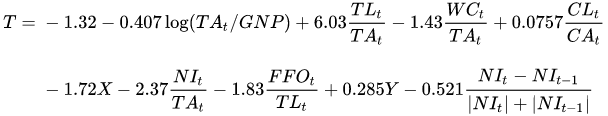)